This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

## Modern convnet architecture patterns

**Residual block where the number of filters changes**

 Assignment -2 : Convolution

Here we will compare the relationship between training samples and the choice of training your model from the new model using a pretrained convolution network.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"swethakanakavalli","key":"b4f64d8a004067c31943fcff585bdfcb"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats

!unzip -qq dogs-vs-cats.zip
!unzip -qq test1.zip
!unzip -qq train.zip

 97% 785M/812M [00:05<00:00, 59.7MB/s]
100% 812M/812M [00:05<00:00, 152MB/s] 


1. Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation 
sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce 
overfitting and improve performance in developing a network that you train from scratch. What 
performance did you achieve?  

Here I am transferring pictures to the test, validation, and training directories

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Initially taking 1000 samples for training set
make_subset("train", start_index=0, end_index=1000)
#500 samples for validation set
make_subset("validation", start_index=1000, end_index=1500)
#500 for test set
make_subset("test", start_index=1500, end_index=2000)

Data Preprocessing : Here I am using the image_dataset_from_directory to read the images

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Building the model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

Here I am using a dataset for Modelfitting

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 16s 86ms/step - loss: 0.7063 - accuracy: 0.5050 - val_loss: 0.6861 - val_accuracy: 0.5990
Epoch 2/30
63/63 [==============================] - 5s 74ms/step - loss: 0.7045 - accuracy: 0.5250 - val_loss: 0.6820 - val_accuracy: 0.5120
Epoch 3/30
63/63 [==============================] - 5s 73ms/step - loss: 0.6865 - accuracy: 0.6030 - val_loss: 0.6553 - val_accuracy: 0.5880
Epoch 4/30
63/63 [==============================] - 5s 73ms/step - loss: 0.6397 - accuracy: 0.6390 - val_loss: 0.6369 - val_accuracy: 0.6310
Epoch 5/30
63/63 [==============================] - 5s 74ms/step - loss: 0.6024 - accuracy: 0.6845 - val_loss: 0.6163 - val_accuracy: 0.6450
Epoch 6/30
63/63 [==============================] - 5s 76ms/step - loss: 0.5683 - accuracy: 0.7110 - val_loss: 0.5657 - val_accuracy: 0.7060
Epoch 7/30
63/63 [==============================] - 5s 77ms/step - loss: 0.5529 - accuracy: 0.7205 - val_loss: 0.7636 - val_accuracy: 0.6020
Epoch 8/30
6

Displaying the training-related loss and accuracy plots

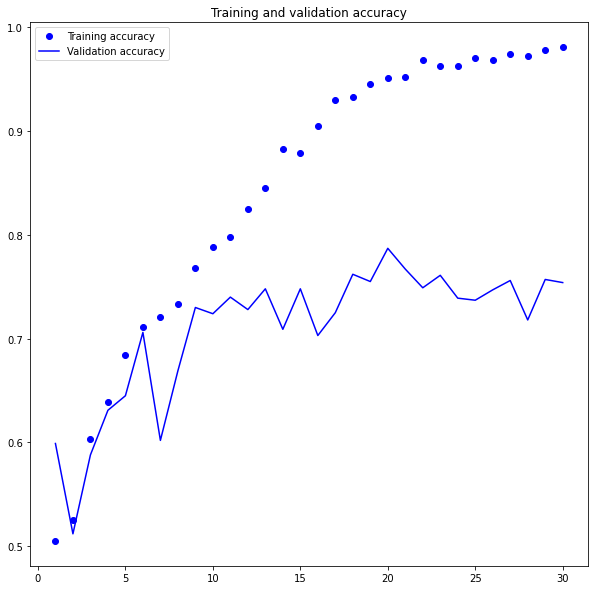

<Figure size 432x288 with 0 Axes>

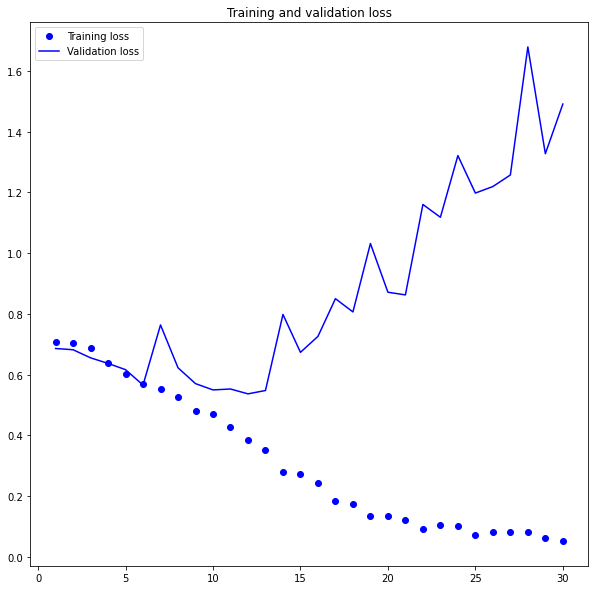

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Model evaluation using the test set

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 36ms/step - loss: 0.6307 - accuracy: 0.7160
Test accuracy: 0.716


Here we got 
Training accuracy : 98.1%
Validation accuracy : 75.4%
Test accuracy :  71.6%


2.2. Increase your training sample size. You may pick any amount. Keep the validation and test 
samples the same as above. Optimize your network (again training from scratch). What 
performance did you achieve? 

Using data augmentation : Establishing a data augmentation stage to be added to an image model

In [ ]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Here I have increased training sample size to 1500 and keeping the validation and test sample size to 500 each as before
make_subset("train", start_index=0, end_index=1500)
make_subset("validation", start_index=1500, end_index=2000)
make_subset("test", start_index=2000, end_index=2500)

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Here I am displaying few randomly augmented training images

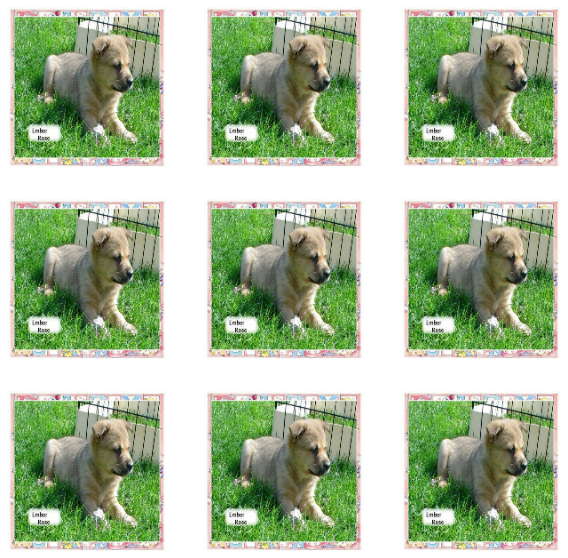

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Now I am defining a new convolutional netwrok that has image augmentation and dropout

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Now I am training the regularized convolutional network

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 8s 99ms/step - loss: 0.7327 - accuracy: 0.4840 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 7s 102ms/step - loss: 0.6949 - accuracy: 0.5075 - val_loss: 0.6900 - val_accuracy: 0.5070
Epoch 3/50
63/63 [==============================] - 6s 97ms/step - loss: 0.6943 - accuracy: 0.5375 - val_loss: 0.6777 - val_accuracy: 0.5650
Epoch 4/50
63/63 [==============================] - 6s 98ms/step - loss: 0.6660 - accuracy: 0.6000 - val_loss: 0.6637 - val_accuracy: 0.5720
Epoch 5/50
63/63 [==============================] - 6s 96ms/step - loss: 0.6574 - accuracy: 0.6205 - val_loss: 1.3795 - val_accuracy: 0.5040
Epoch 6/50
63/63 [==============================] - 6s 96ms/step - loss: 0.6333 - accuracy: 0.6655 - val_loss: 0.6298 - val_accuracy: 0.6310
Epoch 7/50
63/63 [==============================] - 6s 94ms/step - loss: 0.6173 - accuracy: 0.6605 - val_loss: 0.7845 - val_accuracy: 0.5260
Epoch 8/50
6

Model evaluation using the test set

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 39ms/step - loss: 0.4576 - accuracy: 0.8350
Test accuracy: 0.835


Here I got the 
Training accuracy: 88.2%
validation accuracy:80.10%
Test accuracy : 83.5%

3. Now change your training sample so that you achieve better performance than those from Steps 
1 and 2. This sample size may be larger, or smaller than those in the previous steps. The 
objective is to find the ideal training sample size to get best prediction results.

In [ ]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#As increasing the sample size is always good than decreasing, here we're increasing the training the sample size to 2000
make_subset("train", start_index=0, end_index=2000)
#validation and test sample size 500 each
make_subset("validation", start_index=2000, end_index=2500)
make_subset("test", start_index=2500, end_index=3000)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 8s 98ms/step - loss: 0.6946 - accuracy: 0.5110 - val_loss: 0.6919 - val_accuracy: 0.5440
Epoch 2/50
63/63 [==============================] - 6s 95ms/step - loss: 0.6878 - accuracy: 0.5590 - val_loss: 0.6924 - val_accuracy: 0.4990
Epoch 3/50
63/63 [==============================] - 6s 96ms/step - loss: 0.6918 - accuracy: 0.5285 - val_loss: 0.6816 - val_accuracy: 0.5450
Epoch 4/50
63/63 [==============================] - 6s 96ms/step - loss: 0.6835 - accuracy: 0.5595 - val_loss: 0.6644 - val_accuracy: 0.5690
Epoch 5/50
63/63 [==============================] - 6s 97ms/step - loss: 0.6666 - accuracy: 0.6090 - val_loss: 0.6447 - val_accuracy: 0.6360
Epoch 6/50
63/63 [==============================] - 6s 97ms/step - loss: 0.6389 - accuracy: 0.6545 - val_loss: 0.6410 - val_accuracy: 0.5970
Epoch 7/50
63/63 [==============================] - 6s 95ms/step - loss: 0.6312 - accuracy: 0.6615 - val_loss: 0.6278 - val_accuracy: 0.6620
Epoch 8/50
63

Model evaluation using the test set

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 37ms/step - loss: 0.4756 - accuracy: 0.8070
Test accuracy: 0.807


Here I got the 
Training accuracy:80.80%
Validation accuracy:77.60%
Test accuracy:80.7%

4. Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 
for the pretrained network may be the same or different from those using the network where 
you trained from scratch. Again, use any and all optimization techniques to get best 
performance. 

Instantiating the VGG16 convolutional base

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Quick feature extraction , without enhancing the data

Here I am extracting the VGG16 features and corresponding labels

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 17ms/step


In [ ]:
train_features.shape

(2000, 5, 5, 512)

the process of creating and training a densely connected classifier

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 11ms/step - loss: 19.7611 - accuracy: 0.9300 - val_loss: 4.1533 - val_accuracy: 0.9730
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 5.5955 - accuracy: 0.9675 - val_loss: 5.2250 - val_accuracy: 0.9680
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 2.8586 - accuracy: 0.9810 - val_loss: 5.9345 - val_accuracy: 0.9760
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 0.5770 - accuracy: 0.9925 - val_loss: 8.0974 - val_accuracy: 0.9720
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 1.1868 - accuracy: 0.9930 - val_loss: 6.1437 - val_accuracy: 0.9750
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.7512 - accuracy: 0.9930 - val_loss: 5.9459 - val_accuracy: 0.9730
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.4592 - accuracy: 0.9965 - val_loss: 6.4285 - val_accuracy: 0.9740
Epoch 8/20
63/63 [

Plotting all the outcomes

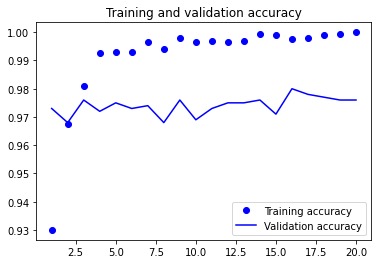

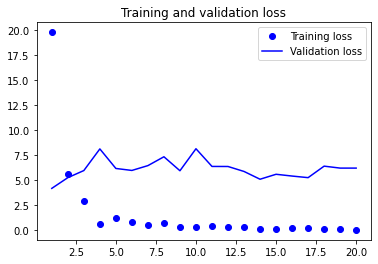

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Feature extraction together with data augmentation and
Instantiating and freezing the VGG16 convolutional base

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

list of trainable weights to be printed before and after freezing

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


Here I am adding a classifier and a data augmentation stage to the convolutional base

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)


Epoch 1/50
63/63 [==============================] - 15s 210ms/step - loss: 16.5421 - accuracy: 0.9005 - val_loss: 9.0125 - val_accuracy: 0.9410
Epoch 2/50
63/63 [==============================] - 13s 204ms/step - loss: 6.3933 - accuracy: 0.9460 - val_loss: 2.5995 - val_accuracy: 0.9790
Epoch 3/50
63/63 [==============================] - 13s 201ms/step - loss: 7.0722 - accuracy: 0.9530 - val_loss: 6.4658 - val_accuracy: 0.9650
Epoch 4/50
63/63 [==============================] - 13s 200ms/step - loss: 4.4020 - accuracy: 0.9605 - val_loss: 5.0639 - val_accuracy: 0.9760
Epoch 5/50
63/63 [==============================] - 13s 199ms/step - loss: 4.4706 - accuracy: 0.9645 - val_loss: 5.3346 - val_accuracy: 0.9680
Epoch 6/50
63/63 [==============================] - 13s 201ms/step - loss: 3.1875 - accuracy: 0.9700 - val_loss: 4.2024 - val_accuracy: 0.9740
Epoch 7/50
63/63 [==============================] - 13s 199ms/step - loss: 3.7643 - accuracy: 0.9685 - val_loss: 9.6577 - val_accuracy: 0.951

Model evaluation using the test set

In [ ]:
 test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 109ms/step - loss: 1.7351 - accuracy: 0.9770
Test accuracy: 0.977


Here I got the
Training accuracy:98.80%
Validation accuracy:97.90%
Test accuracy:97.7%

Modifying the trained model

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Here I am freezing all the layers from the last till fourth

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

Fine-tuning the model

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 16s 224ms/step - loss: 0.7573 - accuracy: 0.9855 - val_loss: 1.3324 - val_accuracy: 0.9850
Epoch 2/30
63/63 [==============================] - 14s 215ms/step - loss: 0.3400 - accuracy: 0.9925 - val_loss: 2.6992 - val_accuracy: 0.9760
Epoch 3/30
63/63 [==============================] - 14s 219ms/step - loss: 0.4483 - accuracy: 0.9895 - val_loss: 1.5284 - val_accuracy: 0.9800
Epoch 4/30
63/63 [==============================] - 14s 217ms/step - loss: 0.2056 - accuracy: 0.9965 - val_loss: 1.9889 - val_accuracy: 0.9810
Epoch 5/30
63/63 [==============================] - 14s 222ms/step - loss: 0.2506 - accuracy: 0.9925 - val_loss: 1.2824 - val_accuracy: 0.9830
Epoch 6/30
63/63 [==============================] - 14s 224ms/step - loss: 0.4363 - accuracy: 0.9895 - val_loss: 1.7994 - val_accuracy: 0.9770
Epoch 7/30
63/63 [==============================] - 14s 217ms/step - loss: 0.3629 - accuracy: 0.9935 - val_loss: 1.4594 - val_accuracy: 0.9790

Model evaluation on the test set

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 112ms/step - loss: 1.5624 - accuracy: 0.9780
Test accuracy: 0.978


Here I got the
Training accuracy :99.65%
Validation accuracy :  98.60%
Test accuracy : 97.8%

Summary:

Firstly i took a small convolutional network of 1000 training samples and validation and test samples of 500 each with no optimization.But here i got the accuracy of 83.5% due to overfitting.

But after that I have added data augmentation , early stopping , dropout  then the accuracy is raised to deacreased to 80.6%. Even with the increase of the training sample size  with the augmentation , the accuracy didnot get better.

model preparation without augmentation Compared to a model created from new model, a pretrained model is more accurate. This validation accuracy was 97.7%, which is significantly higher than the accuracy we would have obtained by starting from new model.

Pretrained model with augmentation Here the validation accuracy slightly increased from 97.7% to 97.8%. With the fine tuning using predefined model I got the test accuracy of 97.8% 

